#  Image Captioning - CNN decoding/LSTM decoding


We are interested in learning a DNN that is capable of generating captions to describe images.

For example:


![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/example.jpg)

caption: **A dog at the beach.**

For training, we will use the Flickr8k dataset ([link](http://nlp.cs.illinois.edu/HockenmaierGroup/8k-pictures.html)). It is a labeled dataset consisting of 8000 photos with 5 captions for each photos. It includes images obtained from the Flickr website.
We  first load the images and descriptions, and then define the model and the learning process.
Finally, we generate captions for new images.
## The Learning problem:
We want to define a supervised learning problem to solve this task. As we have saw in the last lecture and tutorial, we can train a language model using LSTMs. However, in this task, we train a  language model from scratch conditioned on the image we want to describe. 
To accomplish this, we create a representation of "context" given an image, and learn a language model on this representation.

The architecture is designed as follows:
![](https://www.dropbox.com/s/ii2fbpk33c629gl/architecture.jpeg?dl=1)

To generate a caption at test time we simply feed an image to the model with a "start sequence" input, and use the most likely predicted next word sequentially until reaching an "end sequence" character.
Thus, we use a **greedy** strategy (recall that beam search can be better)

The merge layer can appear before or after the LSTM, (see [link](https://arxiv.org/pdf/1703.09137.pdf)). And the merge can be either addition or concatenation.

Some of the code is based on a the following blogpost  [machinelearningmastery.com](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/)



## Loading Images and Extracting Features
Our model will be based on features extracted from a pretrained CNN (on imagenet). The following code  loads the images and extract features using a pretrained VGG16 network.
It produces a vector of 4096 features for each image.
Finally the features of all images are saved to a file for future use.


In [ ]:
from pickle import dump
from os import listdir
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
 
# extract features from each photo in the directory
def extract_features(directory):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# summarize
	print(model.summary())
	# extract features from each photo
	features = dict()
	for name in listdir(directory):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
		# print('>%s' % name)
	return features
 
# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))


/home/yonatan/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Loading Captions
We clean the descriptions loaded from the file (remove bad character sequences like ?!#$,  change to lower case, etc.), and save as a corpus of integers.

In [ ]:
import string
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping
 
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)
 
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc
 
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 
filename = 'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


## Load data for training
Here are several functions used to load the image features and descriptions and prepare for training.


In [ ]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions
 
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
 

We take each description (with its image) and decompose it to a supervised next word prediction dataset. For any initial part of a description, its label will be the next word.

For example:

X1[i] = image features (4096 vector)

X2[i] = intro of description of some length

y[i] = the next word of that description

In [ ]:
from pickle import dump



# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)
 
# train dataset
 
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)
 
# dev dataset
 
# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features)
 

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000


## Define Model and Train
We now define the model and train it. We use the Keras functinoal API to build a multiple input network.

In [ ]:

# fit model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.3)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.3)(se1)
    
    #merge layer
    merge = add([fe2, se2])
    #language model
    decoder1 = LSTM(256)(merge)
    
    #fully connected
    decoder2 = Dense(256, activation='relu')(decoder1)
    bn = BatchNormalization()(decoder2)
    do = Dropout(0.1)(bn)
    decoder3 = Dense(512, activation='relu')(do)
    bn = BatchNormalization()(decoder3)
    do = Dropout(0.1)(bn)
    outputs = Dense(vocab_size, activation='softmax')(do)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model
 
# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (D

KeyboardInterrupt: 

## Evaluating Generated Captions

We use the BLEU measure to evaluate the result of the the test set generated captions.
The BLEU (will be covered next class) is simply taking the fraction of n-grams in the predicted sentence that appears in the ground-truth. BLEU-1 is the precision of predicting uni-grams. For example when the reference is "the dog jumped", when predicting "dog jumped" the BLEU will be 2/2. However, the sentence "the the the" also have BLEU-1 of 1. Thus, an n-gram counts only the number of times the n-gram appears in the ground truth. As a consequence, the BLEU for "the the the" will be 1/3.



In [ ]:


from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
 
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
 

BLEU-1: 0.547805
BLEU-2: 0.322334
BLEU-3: 0.236491
BLEU-4: 0.121023


## Generate Captions for Images

 group of people are standing in front of building 


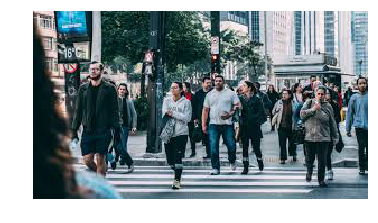

 brown dog is running through the grass 


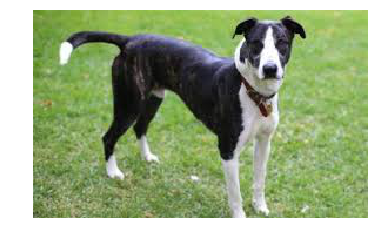

 boy in blue shirt is jumping on trampoline 


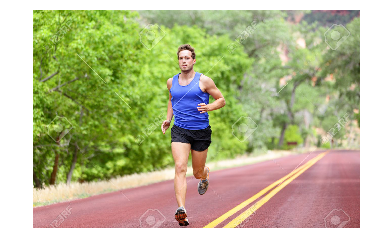

 group of people are standing in the street 


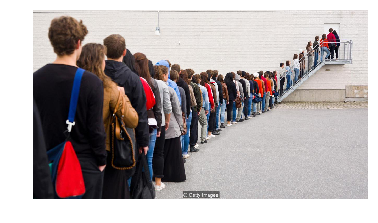

 two children are playing in the bathtub 


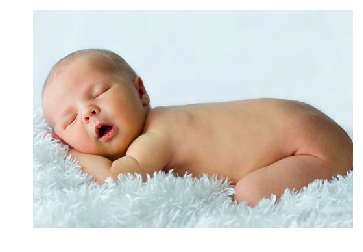

 man in red shirt is running after soccer ball 


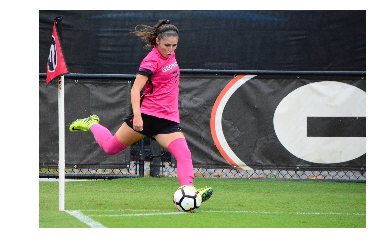

 boy in blue shirt is standing on the edge of the water 


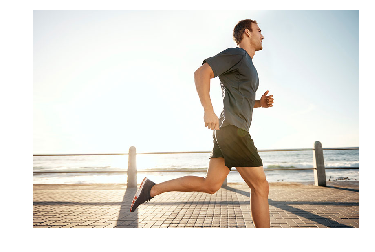

In [ ]:
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
from pickle import load
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text
 
# extract features from each photo in the directory
def extract_features(filename):
  # load the model
  model = VGG16()
  # re-structure the model
  model.layers.pop()
  model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
  # load the photo
  image = load_img(filename, target_size=(224, 224))
  # convert the image pixels to a numpy array
  image = img_to_array(image)
  # reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
  image = preprocess_input(image)
  # get features
  feature = model.predict(image, verbose=0)
  del model
  return feature
 
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
 
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('model-ep015-loss3.385-val_loss3.629.h5')
# load and prepare the photograph
photos = ['example.jpg','example2.jpg','example3.jpg','example4.jpg','example5.jpg','example6.JPG','example7.jpg']
for fname in photos:
  photo = extract_features(fname)
  
  # generate description
  description = generate_desc(model, tokenizer, photo, max_length)
  print(description[8:-6])
  img=mpimg.imread(fname)
  imgplot = plt.imshow(img)
  plt.axis('off')

  plt.show()
del model

# Training with time distributed layers

In [ ]:
import random
import numpy as np

def data_generator(tokenizer, max_length, descriptions, photos, vocab_sizze, batch_size = 128):

    while 1:
        keys =  [key for (key,desc_list) in descriptions.items()]
        idx = list(range(len(keys)))
        random.shuffle(idx)
        for ind in  range(0,len(idx),batch_size):
            X1, X2, y = list(), list(), list()

            for i in range(batch_size):
                key = keys[idx[ind+i]]
                desc_list = descriptions[key]
                for desc in desc_list:
                    X1.append(photos[key][0])
                    X2.append(pad_sequences([tokenizer.texts_to_sequences([desc])[0]],maxlen=max_length)[0])
                    y_ = np.roll(X2[-1], -1, axis=-1)  # we want to predict the next character
                    y.append(np.array(to_categorical(y_, num_classes=vocab_size)))   
            yield [array(X1), array(X2)], array(y)

from keras.layers import TimeDistributed
# fit model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.3)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.3)(se1)
    
    #merge layer
    merge = add([fe2, se2])
    #language model
    decoder1 = LSTM(256,return_sequences=True)(merge)
    
    #fully connected
    decoder2 = TimeDistributed(Dense(256, activation='relu'))(decoder1)
    bn = BatchNormalization()(decoder2)
    do = Dropout(0.1)(bn)
    decoder3 = TimeDistributed(Dense(512, activation='relu'))(do)
    bn = BatchNormalization()(decoder3)
    do = Dropout(0.1)(bn)
    outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(do)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model
 
# define the model

model = define_model(vocab_size, max_length)
batch_size = 32
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
model.fit_generator(data_generator(tokenizer, max_length, train_descriptions, train_features,vocab_size, batch_size = 32),
                        samples_per_epoch=6000//batch_size,
                        nb_epoch=20,
                        validation_data=data_generator(tokenizer, max_length, test_descriptions, test_features,vocab_size, batch_size = 32),
                        nb_val_samples=2000//batch_size,callbacks = [checkpoint],
                        verbose=2)